### Objective

Objective of this excercise is to define own kNN functions with custom distance metric and perform kNN algorithm on given dataset.
Let's take a quick look at the dataset

In [1]:
rm(list=ls())
load("Classification_160412IV_16.RData")
colnames(PointsTraining) <- c('x','y','cluster')
colnames(PointsValidation) <- c('x','y','cluster')

In [34]:
cat("Training Set rows", nrow(PointsTraining))
cat("\nValidation Set rows", nrow(PointsValidation))

Training Set rows 2000
Validation Set rows 400

In [35]:
print("Training Set")
head(PointsTraining)
print("Validation Set")
head(PointsValidation)

[1] "Training Set"


x,y,cluster
-26.42991,24.38948,2
-26.82981,23.51648,2
-27.26956,23.49114,2
-27.51331,22.99301,2
-27.20335,23.79816,2
-26.37155,23.47225,2


[1] "Validation Set"


x,y,cluster
-9.465685,6.388837,1
-20.108337,9.892604,1
-11.104884,25.277316,1
-27.925423,26.516064,1
-32.407557,33.990428,1
-9.850226,17.427971,1


## Dataset
Training data sets consists of 2000 x,y points with corresponding color class. 
Validation set has 400 data points with same attributes.
Next step I am going to plot the points to see the distribution

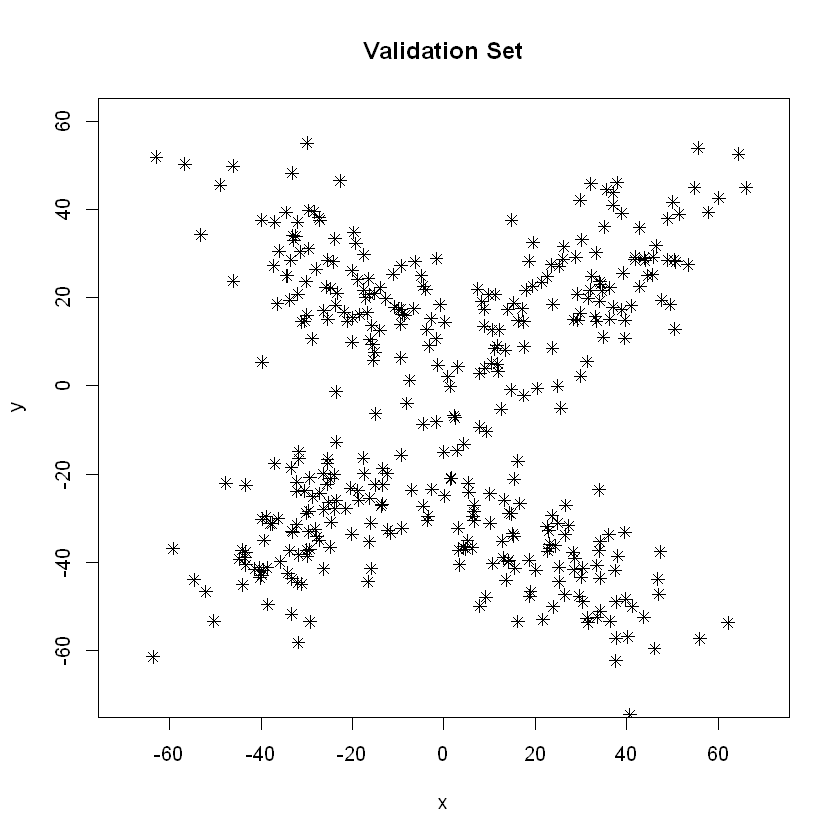

In [4]:
plot(PointsValidation,type = "p",pch=8,col='black',xlim=c(-70,70),ylim=c(-70,60),main="Validation Set",xlab="x",ylab="y")

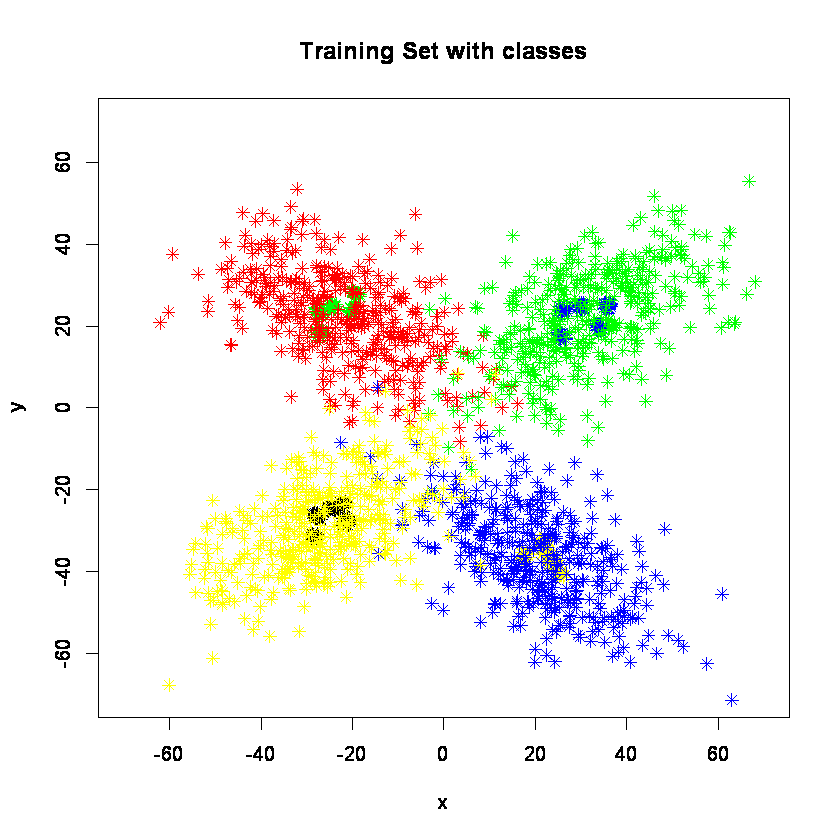

In [5]:
for(j in seq(along=PointsTraining[,1])){
    color_set<-switch(PointsTraining[j,3], "red","green","blue","yellow","black","violet","purple")
    plot(PointsTraining[j,1],PointsTraining[j,2],type = "p",pch=8,col=color_set,xlim=c(-70,70),ylim=c(-70,70),main="Training Set with classes",xlab="x",ylab="y")
       par(new=TRUE)
    }

As we can see from the plots data distribution is X-shaped. The colored Training Set shows us 4 clusters generally starting in the middle point of an X and going aside from the center. There is however some noise within groups visible as underlying points that clearly do not match the color. Let's see how the kNN algorithm will handle that on validation set.

## Functions 
- Firstly I define function to compute each distance (Euclidean, Minkowsky, Manhattan, Canberra).
- myKNN function goal is to classify each Validation Set point by calculating the distance to the closest Training Set points and voting which color (group) should be applied. It can be used with each of the montioned above distance and it takes as a parameter an odd number of neighbours to be accounted in a vote. e parameter is used as a power in Minkowsky distance.
- Validation function counts the relative number of misclassified points

In [6]:
my_distance<-function(point, matrix, type, e){
  dimensions=length(matrix[,1]) 
  dist<-matrix(,dimensions,2)  # empty matrix initialization, dimension from Training Set
  for(i in seq(matrix[,1])){ #loop - count distance of given 'point' along all points of Validation Set
    
    if(type=="Euclidean"){
      dist[i,1]<-sqrt((point[1]-matrix[i,1])^2+(point[2]-matrix[i,2])^2) 
    }
    
    if(type=="Minkowsky"){
      dist[i,1]<-((abs(point[1]-matrix[i,1]))^e+abs((point[2]-matrix[i,2]))^e)^(1/e)
    }
    
    if(type=="Manhattan"){
      dist[i,1]<-abs((point[1]-matrix[i,1]))+abs((point[2]-matrix[i,2]))
    }
    
    if(type=="Canberra"){
      dist[i,1]<-(abs((point[1]-matrix[i,1]))/(abs(point[1])+abs(matrix[i,1])))+
                    (abs((point[2]-matrix[i,2]))/(abs(point[2])+abs(matrix[i,2])))
    }
    
    dist[i,2]<-i
    
  }
  return(dist)
}

# --------------------------------------------------------------------------------------------------

my_kNN<-function(TrainingSet, ValidationSet, k, distance, e){
  color_vote<-matrix(,k,1) #initialize kX1 matrix
  Results<-matrix(,length(ValidationSet[,1]),6) #initialize kX6 matrix

  for(j in seq(along=ValidationSet[,1])){
    #count distances for each set of points and save in M1 matrix
    M1<-my_distance(ValidationSet[j,], TrainingSet[,], distance, e) # find the shortest distances
    M1_match<-M1[,1][order(M1[,1])] #order ascending and save dist of X values to M1_match
    M2_match<-M1[,2][order(M1[,1])] #order ascending and save dist of Y values id to M2_match
  
    # find coresponding colors for given cluster in Training Set
    for(c in seq(1,k)){
    color_vote[c]<-TrainingSet[M2_match[c],3] # save color numbers of first k points to matrix
    } 
    
    # Count number of occurance for each color from Training set in proximity of the Validation point
    color_v<-table(color_vote) #count occurances of each value
    
    #vote
    colr=as.table(which.max(color_v)) #show only color with max number of occurance
    col=as.numeric(row.names(colr)) #return row name (color value) as number
    
    #choose color as named value (predicted by kNN)
    color<-switch(col,"red","green","blue","yellow","black","violet","purple")
    #chose color as named value (ground truth info)
    color_set<-switch(ValidationSet[j,3], "red","green","blue","yellow","black","violet","purple")

    #save results to matrix
     Results[j,1] <- ValidationSet[j,1]
     Results[j,2] <- ValidationSet[j,2]
     Results[j,3] <- ValidationSet[j,3]
     Results[j,4] <- col
     Results[j,5] <- color
     Results[j,6] <- color_set
  }
    
  return(Results)
}

# --------------------------------------------------------------------------------------------------

my_Evaluation<-function(Test,Validation){
  error=0
  for(i in seq(along=Validation)){
    if(Validation[i]!=strtoi(Test[i])){
      error=error+1
    }
  }
  return(error/length(Test))
}  

# --------------------------------------------------------------------------------------------------

plot_charts <- function(Result,title){
# PLOT points with appropriate color   

    #plot predicted clusters
    plot(Result[,1],Result[,2],type = "p",pch=8,cex=0.9,col=Result[,5],xlim=c(-70,70),ylim=c(-70,70),main=title,xlab="x",ylab="y")
       par(new=TRUE)
    # plot factual clusters
    plot(Result[,1],Result[,2],type = "p",cex=0.9,col=Result[,6],xlim=c(-70,70),ylim=c(-70,70),xlab="x",ylab="y")
       par(new=TRUE)

}

## Testing different parameters
For coded type of distance metric, I want to check different setup of K (number of neighbours) parameter. Below testing different values between 1 and 21. In case of Minkowsky it's the distance power that is being tested instead of number of neighbours.

Please mind, the following cell takes a few minutes to execute

In [2]:
result_matrix <- matrix(,11,5)
r=0
dist = c("Euclidean","Minkowsky","Manhattan","Canberra")
for(i in seq(1,21,2)){
    c=0
    r=r+1
    for(j in dist){
        c=c+1
        if(j=="Minkowsky"){
            res <- my_kNN(PointsTraining,PointsValidation,5,j,i)
        }else{
            res <- my_kNN(PointsTraining,PointsValidation,i,j,0)
            }
        error <- my_Evaluation(res[,4],PointsValidation[,3])

        result_matrix[r,1] = i
        result_matrix[r,c+1] = error
    }
}
colnames(result_matrix) <- c("k",dist)
result_matrix

ERROR: Error in my_kNN(PointsTraining, PointsValidation, i, j, 0): nie udało się znaleźć funkcji 'my_kNN'


Best results (lowest miclassification rate) are achieved for following parameters
- Euclidean, k=5
- Minkowsky, power of 3
- Manhattan, k=3
- Canberra, k=7

In the next step I will plot the output classes and sum up findings

In [24]:
Results1<-my_kNN(PointsTraining,PointsValidation,5,"Euclidean",0)
Results2<-my_kNN(PointsTraining,PointsValidation,5,"Minkowsky", 3)
Results3<-my_kNN(PointsTraining,PointsValidation,3,"Manhattan",0)
Results4<-my_kNN(PointsTraining,PointsValidation,7,"Canberra",0)

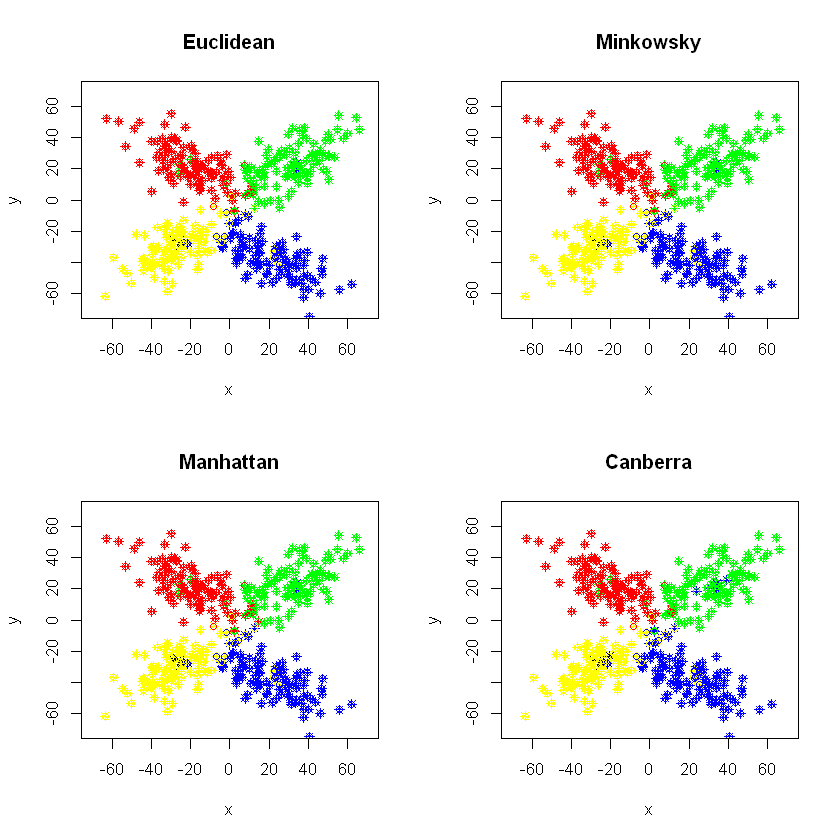

In [31]:
par(mfrow=c(2,2))
plot_charts(Results1,"Euclidean")
par(new=FALSE)
plot_charts(Results2,"Minkowsky")
par(new=FALSE)
plot_charts(Results3,"Manhattan")
par(new=FALSE)
plot_charts(Results4,"Canberra")

Some of the points were misclasiffied. Error rate for taken parameter looks as below

In [32]:
error1<-my_Evaluation(Results1[,4],PointsValidation[,3])
error2<-my_Evaluation(Results2[,4],PointsValidation[,3])
error3<-my_Evaluation(Results3[,4],PointsValidation[,3])
error4<-my_Evaluation(Results4[,4],PointsValidation[,3])

In [33]:
results<-cbind(Results1[,3],Results2[,4],Results3[,4],Results4[,4],PointsValidation[,3])
errors<-cbind(error1,error2,error3,error4)
colnames(results)<-c("Euclidean","Minkowsky","Manhattan","Canberra","TrueClass")
colnames(errors)<-c("Euclidean","Minkowsky","Manhattan","Canberra")

errors

Euclidean,Minkowsky,Manhattan,Canberra
0.085,0.0875,0.095,0.095


As we can see the lowest error was drawn on kNN classification with Euclidean distance applied. Error rate is 8.5%. Other distances performed slightly worse, getting 8.75% Minkowsky and 9.5% for both Manhattan and Canberra.
It is possible that experimenting with other distances can bring better results, however 91.5% rate of proper classification seems for now acceptable.